In [ ]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.isnull().sum()

,0
Target,0
Text,0


In [ ]:
df.duplicated().sum()

403

In [ ]:
df.drop_duplicates(inplace=True)

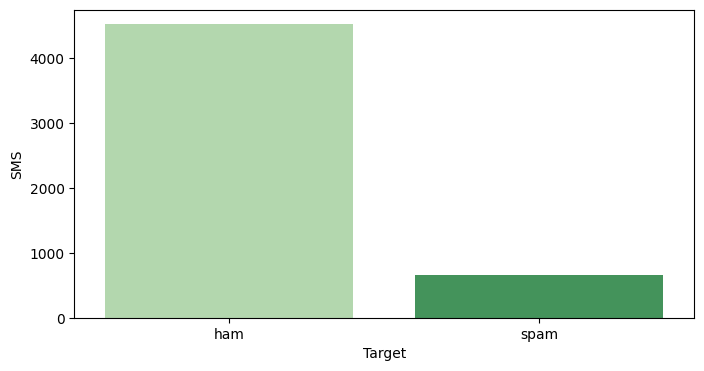

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Target', palette='Greens')
plt.xlabel("Target")
plt.ylabel("SMS")
plt.show()

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

df['No of Chars'] = df['Text'].apply(len)
df['No of Sentences'] = df['Text'].apply(lambda corpus: nltk.sent_tokenize(corpus)).apply(len)
df['No of Words'] = df['Text'].apply(lambda document: nltk.word_tokenize(document)).apply(len)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No of Chars,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No of Sentences,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0
No of Words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0


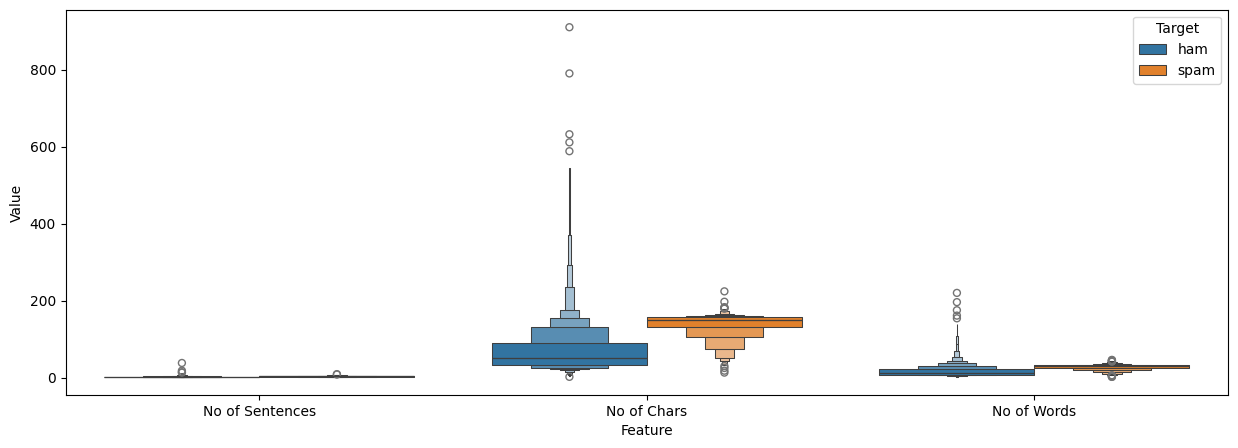

In [ ]:
melted_df = df.melt(id_vars='Target', value_vars=['No of Sentences', 'No of Chars', 'No of Words'], var_name='Feature', value_name='Value')

plt.figure(figsize=(15,5))
sns.boxenplot(x='Feature', y='Value', data=melted_df, hue='Target')
plt.show()

In [ ]:
column_name = 'No of Chars'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
outliers.index

Index([  53,  126,  154,  380,  424,  472,  550,  710,  837,  881, 1084, 1359,
       1384, 1512, 1578, 1585, 1826, 1862, 2009, 2011, 2064, 2089, 2133, 2157,
       2355, 2369, 2379, 2407, 2433, 2492, 2502, 2544, 2614, 2855, 2944, 3015,
       3039, 3058, 3105, 3225, 3304, 3349, 3452, 3516, 3564, 3730, 3736, 3777,
       3820, 3878, 4055, 4079, 4289, 4310, 4397, 4407, 4450, 4800, 4865, 4903,
       5003, 5082, 5209, 5451, 5515, 5557],
      dtype='int64')

In [ ]:
df.drop(outliers.index, axis=0, inplace=True)


In [ ]:
df.shape

(5103, 5)

In [ ]:
def data_cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # replacing all non-alphabetix characters with space
    text = str.lower(text) # lowercasing
    text = text.split()    # splitting string into list
    text = ' '.join(text)  # join all items of the list
    return text
df['Clean Text'] = df['Text'].apply(data_cleaning)


In [ ]:
df['Tokenized Text'] = df['Clean Text'].apply(lambda document: nltk.word_tokenize(document))

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def stopwords_removal(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text


# applying stopwords removal
df['Filtered Token'] = df['Tokenized Text'].apply(stopwords_removal)

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

# Function to lemmatize
def lemmatizing(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas


df['Lemmatized Tokens'] = df['Filtered Token'].apply(lemmatizing)

In [ ]:
corpus = []
for tokens in df['Lemmatized Tokens']:
    document = ' '.join([word for word in tokens])
    corpus.append(document)

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [ ]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
df['Target'] = df['Target'].map({"ham":0, "spam":1})
y = df['Target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier()]
clf_dict = { 0: "Logistic Regression",
             1: "NaiveBayes",
             2: "RandomForest",
             3: "KNeighbours",}

In [ ]:
evaluation_results = []

for i, model in enumerate(classifiers):
    # Perform 10-fold cross-validation
    cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results to the list
    evaluation_results.append({
        'Model': clf_dict[i],
        'Cross-Validation Accuracy': cv_score.mean(),
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"{clf_dict[i]}: {round(accuracy*100, 2)}%")

Logistic Regression: 95.98%
NaiveBayes: 97.26%
RandomForest: 97.55%
KNeighbours: 92.16%


In [ ]:
evaluation_df = pd.DataFrame(evaluation_results)
metric_category = ['Cross-Validation Accuracy', 'Test Accuracy', 'Precision','Recall', 'F1 Score']
evaluation_df[metric_category] = round(evaluation_df[metric_category]*100, 6)

# Displaying Model Evalutions
evaluation_df.style.background_gradient(cmap='Greens')

,Model,Cross-Validation Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,95.247255,95.984329,96.002512,95.984329,95.679783
1,NaiveBayes,96.104859,97.257591,97.304671,97.257591,97.110499
2,RandomForest,97.305060,97.551420,97.561177,97.551420,97.448126
3,KNeighbours,90.690949,92.164545,92.599122,92.164545,90.440775


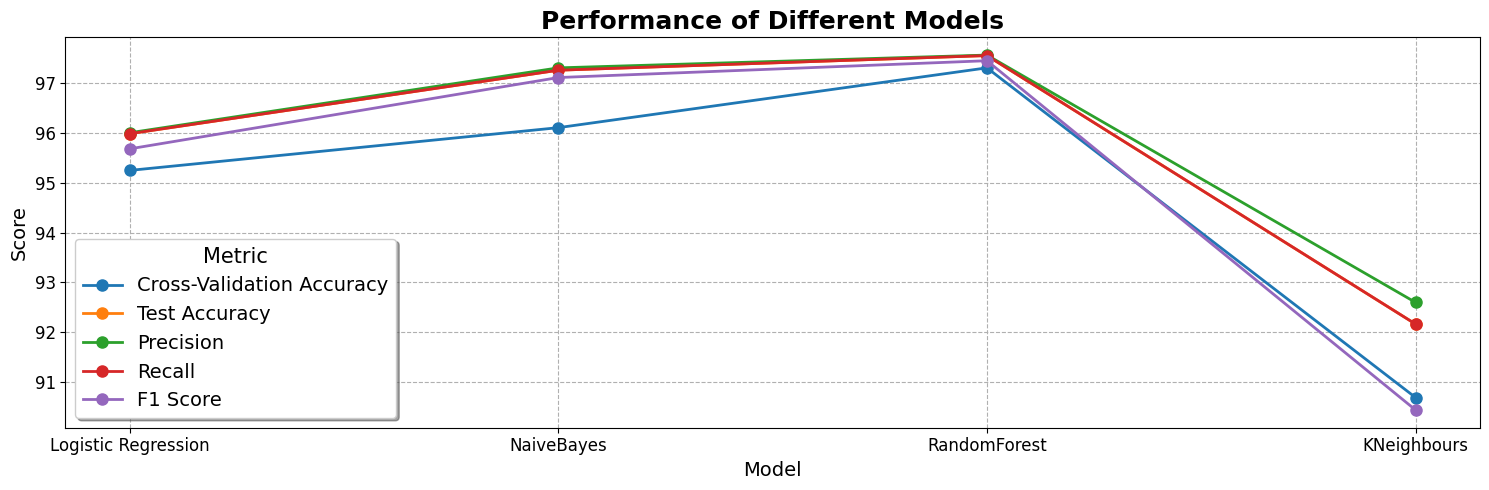

In [ ]:
plt.figure(figsize=(15, 5))

for i, metric in enumerate(evaluation_df.columns[1:]):
    plt.plot(evaluation_df['Model'], evaluation_df[metric], marker='o', linestyle='-', linewidth=2,  markersize=8, label=metric)

plt.title('Performance of Different Models', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=1)
plt.legend(title='Metric', title_fontsize='15', fontsize='14', loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

evaluation_results = []

for i, model in enumerate(classifiers):
    # Perform 10-fold cross-validation
    cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results to the list
    evaluation_results.append({
        'Model': clf_dict[i],
        'Cross-Validation Accuracy': cv_score.mean(),
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"{clf_dict[i]}: {round(accuracy*100, 2)}%")

    # Save the model using pickle
    model_filename = f'{clf_dict[i].replace(" ", "_").lower()}_model.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as {model_filename}")

print("\nAll models have been evaluated and saved.")

# Create DataFrame of evaluation results (optional, but useful for comparison)
evaluation_df = pd.DataFrame(evaluation_results)
print("\nEvaluation Results:")
print(evaluation_df)

Logistic Regression: 95.98%
Model saved as logistic_regression_model.pkl
NaiveBayes: 97.26%
Model saved as naivebayes_model.pkl
RandomForest: 98.04%
Model saved as randomforest_model.pkl
KNeighbours: 92.16%
Model saved as kneighbours_model.pkl

All models have been evaluated and saved.

Evaluation Results:
                 Model  Cross-Validation Accuracy  Test Accuracy  Precision  \
0  Logistic Regression                   0.952473       0.959843   0.960025   
1           NaiveBayes                   0.961049       0.972576   0.973047   
2         RandomForest                   0.973784       0.980411   0.980603   
3          KNeighbours                   0.906909       0.921645   0.925991   

     Recall  F1 Score  
0  0.959843  0.956798  
1  0.972576  0.971105  
2  0.980411  0.979714  
3  0.921645  0.904408  


In [ ]:
import pickle

logistic_model=pickle.load(open("/content/logistic_regression_model.pkl","rb"))
naivebayes_model=pickle.load(open("/content/naivebayes_model.pkl","rb"))


def predict(spam_or_ham):
   prediction_one=logistic_model.predict(spam_or_ham)
   prediction_two=naivebayes_model.predict(spam_or_ham)
   print(f"Logistic Regression: {prediction_one}")
   print(f"Naive Bayes: {prediction_two}")


predict("This is an advetisment")

ValueError: Expected 2D array, got scalar array instead:
array=This is an advetisment.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Load the models
logistic_model = pickle.load(open("/content/logistic_regression_model.pkl", "rb"))
naivebayes_model = pickle.load(open("/content/naivebayes_model.pkl", "rb"))

# Assume the same vectorizer was used during model training
vectorizer = pickle.load(open("/content/vectorizer.pkl", "rb"))

def predict(text):
    # Convert the text to the required format (vectorize the text)
    transformed_text = vectorizer.transform([text])

    # Make predictions using the loaded models
    prediction_one = logistic_model.predict(transformed_text)
    prediction_two = naivebayes_model.predict(transformed_text)

    print(f"Logistic Regression: {prediction_one[0]}")
    print(f"Naive Bayes: {prediction_two[0]}")

# Example usage
predict("Free entry in 2 a wkly comp to win FA Cup")


Logistic Regression: 0
Naive Bayes: 1


In [ ]:
import json
import requests

url="https://ocr.asprise.com/api/v1/receipt"
image="/content/bill1.png"

res=requests.post(
    url,
    data={
        'api_key':'TEST'
        'recognizer': 'auto',
        'ref_no':'oct_python_123'
    },
    files={
        'file':open(image, 'rb')
    }
)

In [ ]:
import re

def extract_numeric_value(message):
    numeric_pattern = r"\b(?:Rs\.?|Rs)\s?(\d+\.?\d*)\b"
    match = re.search(numeric_pattern, message)
    if match:
        return match.group(1)
    return None

# Example usage
message = "Your account was debited with 500.0 for the transaction."
result = extract_numeric_value(message)
print(result)  # Output: 500.0


None


In [ ]:
import re

def extract_numeric_value(message):
    # Regex pattern to capture a number that follows "Rs", "Rs.", or "₹"
    numeric_pattern = r"\b(?:Rs\.?|₹)\s?(\d+\.?\d*)\b"
    match = re.search(numeric_pattern, message)
    if match:
        return match.group(1)  # Return the numeric value following "Rs.", "Rs", or "₹"
    return None

# Example usage
message_1 = "Your account was debited with Rs. 500.0 for the transaction."
message_2 = "Your account was debited with ₹750 for the transaction."
message_3 = "Rs 1000 was credited to your account."
result_1 = extract_numeric_value(message_1)
result_2 = extract_numeric_value(message_2)
result_3 = extract_numeric_value(message_3)

print(result_1)  # Output: 500.0
print(result_2)  # Output: 750
print(result_3)  # Output: 1000


500.0
None
1000
